## Using Under GDPR as my treatment indicator instead of EU status

In [2]:
import pandas as pd
df_new = pd.read_csv("df_sentiment_fullreview_ready.csv")

C:\Users\Ethan D\AppData\Local\Temp\ipykernel_12544\3116746666.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new = pd.read_csv("df_sentiment_fullreview_ready.csv")


In [3]:
# Convert everything to string first to handle all formats
df_new['founded_year'] = df_new['founded_year'].astype(str)

# Remove quotes and leading/trailing whitespaces
df_new['founded_year'] = df_new['founded_year'].str.replace('"', '').str.strip()

# Convert to numeric (coerce errors to NaN if unconvertible)
df_new['founded_year'] = pd.to_numeric(df_new['founded_year'], errors='coerce')

# Check the cleaned values
print(df_new['founded_year'].describe())


count    2.151491e+06
mean     1.937624e+03
std      5.962299e+01
min      1.096000e+03
25%      1.904000e+03
50%      1.957000e+03
75%      1.983000e+03
max      2.021000e+03
Name: founded_year, dtype: float64


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import pandas as pd

# Step 1: Binary encode treatment (using under_gdpr as the actual treatment)
df_new['treated'] = df_new['under_gdpr'].map({'Yes': 1, 'No': 0})

# Step 2: Drop rows with missing data
psm_data = df_new.dropna(subset=[
    'company_size', 'founded_year', 'seniority_level',
    'CEO_Approval_Sentiment', 'Business_Outlook_Sentiment', 'Recommmend_sentiment'
])

# Step 3: One-hot encode categorical covariates
psm_data = pd.get_dummies(psm_data, columns=['company_size', 'seniority_level'], drop_first=True)

# Step 4: Define covariates including sentiment + encoded dummies
covariates = [
    'founded_year',
    'CEO_Approval_Sentiment',
    'Business_Outlook_Sentiment',
    'Recommmend_sentiment'
] + [col for col in psm_data.columns if 'company_size_' in col or 'seniority_level_' in col]

# Step 5: Estimate propensity scores
logit = LogisticRegression(max_iter=1000)
logit.fit(psm_data[covariates], psm_data['treated'])

# Step 6: Add propensity scores to the DataFrame
psm_data['propensity_score'] = logit.predict_proba(psm_data[covariates])[:, 1]

# Step 7: Split into treated and control
treated = psm_data[psm_data['treated'] == 1]
control = psm_data[psm_data['treated'] == 0]

# Step 8: Nearest-neighbor matching (with replacement)
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])
matched_control = control.iloc[indices.flatten()]

# Step 9: Combine matched treated and control units
matched_df = pd.concat([treated.reset_index(drop=True), matched_control.reset_index(drop=True)])




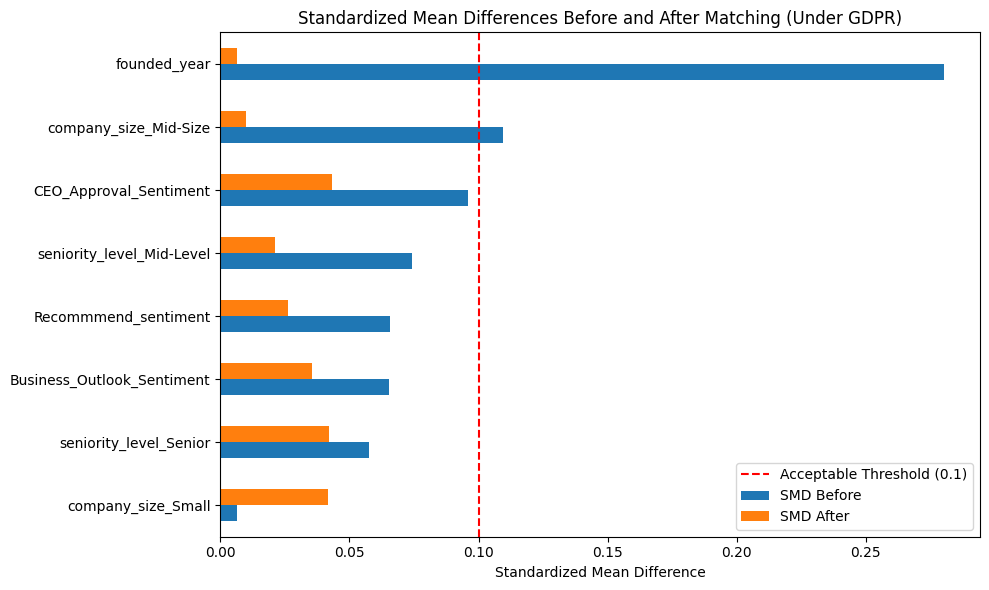

                            SMD Before  SMD After
Business_Outlook_Sentiment       0.065      0.036
CEO_Approval_Sentiment           0.096      0.043
Recommmend_sentiment             0.066      0.026
company_size_Mid-Size            0.109      0.010
company_size_Small               0.007      0.042
founded_year                     0.280      0.007
seniority_level_Mid-Level        0.074      0.021
seniority_level_Senior           0.057      0.042


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Ensure binary treatment indicator exists (based on under_gdpr)
if 'treated' not in psm_data.columns:
    psm_data['treated'] = psm_data['under_gdpr'].astype(int)

if 'treated' not in matched_df.columns:
    matched_df['treated'] = matched_df['under_gdpr'].astype(int)

# Step 2: Define covariates (update as needed)
covariates = [
    'founded_year',
    'CEO_Approval_Sentiment',
    'Business_Outlook_Sentiment',
    'Recommmend_sentiment',  # fix spelling if necessary
    'company_size_Mid-Size',
    'company_size_Small',
    'seniority_level_Mid-Level',
    'seniority_level_Senior'
]

# Step 3: Split treated/control groups pre- and post-matching
treated_full = psm_data[psm_data['treated'] == 1]
control_full = psm_data[psm_data['treated'] == 0]

treated_matched = matched_df[matched_df['treated'] == 1]
control_matched = matched_df[matched_df['treated'] == 0]

# Step 4: Safe SMD function
def compute_smd(treated, control, covariates):
    smd = {}
    for col in covariates:
        if col in treated.columns and col in control.columns:
            if pd.api.types.is_numeric_dtype(treated[col]) and pd.api.types.is_numeric_dtype(control[col]):
                treat_mean = treated[col].mean()
                control_mean = control[col].mean()
                pooled_std = np.sqrt((treated[col].var() + control[col].var()) / 2)
                smd[col] = np.abs(treat_mean - control_mean) / pooled_std if pooled_std != 0 else 0
    return pd.Series(smd).sort_values(ascending=False)

# Step 5: Compute SMDs
smd_before = compute_smd(treated_full, control_full, covariates)
smd_after = compute_smd(treated_matched, control_matched, covariates)

# Step 6: Combine and plot
smd_df = pd.DataFrame({
    'SMD Before': smd_before,
    'SMD After': smd_after
}).dropna().astype(float)

# Step 7: Plot Love Plot
smd_df.sort_values("SMD Before", ascending=True).plot(kind='barh', figsize=(10, 6))
plt.axvline(0.1, color='red', linestyle='--', label='Acceptable Threshold (0.1)')
plt.title('Standardized Mean Differences Before and After Matching (Under GDPR)')
plt.xlabel('Standardized Mean Difference')
plt.legend()
plt.tight_layout()
plt.show()

# Optional: Print or export
print(smd_df.round(3))
# smd_df.to_csv("smd_summary_under_gdpr.csv", index=True)


In [7]:
# Number of total reviews before matching
n_reviews_before = len(psm_data)

# Number of unique companies before matching
n_companies_before = psm_data['company_name'].nunique()

# Number of total reviews after matching
n_reviews_after = len(matched_df)

# Number of unique companies after matching
n_companies_after = matched_df['company_name'].nunique()

# Display results
print("🔍 Before Matching:")
print(f"  Total reviews: {n_reviews_before}")
print(f"  Unique companies: {n_companies_before}")

print("\n✅ After Matching:")
print(f"  Total reviews: {n_reviews_after}")
print(f"  Unique companies: {n_companies_after}")


🔍 Before Matching:
  Total reviews: 2151491
  Unique companies: 1662

✅ After Matching:
  Total reviews: 2639670
  Unique companies: 1589


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))

sns.kdeplot(data=psm_data[psm_data['eu_status_binary'] == 1], x='propensity_score', label='Treated (Before)', shade=True)
sns.kdeplot(data=psm_data[psm_data['eu_status_binary'] == 0], x='propensity_score', label='Control (Before)', shade=True)

plt.title('Propensity Score Distribution Before Matching')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.show()


In [8]:
# Optional: Save matched dataset
#matched_df.to_csv("NEW_best_propensity_matched_dataset_under_gdpr.csv", index=False)

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Define a function to get compound sentiment score
def get_vader_score(text):
    if isinstance(text, str):
        return analyzer.polarity_scores(text)['compound']
    else:
        return None  # In case there are NaNs or non-strings

# Apply to 'full_review' column
matched_df['vader_sentiment'] = matched_df['full_review'].apply(get_vader_score)


In [9]:
# Number of total reviews before matching
n_reviews_before = len(psm_data)

# Number of unique companies before matching
n_companies_before = psm_data['company_name'].nunique()

# Number of total reviews after matching
n_reviews_after = len(matched_df)

# Number of unique companies after matching
n_companies_after = matched_df['company_name'].nunique()

# Display results
print("🔍 Before Matching:")
print(f"  Total reviews: {n_reviews_before}")
print(f"  Unique companies: {n_companies_before}")

print("\n✅ After Matching:")
print(f"  Total reviews: {n_reviews_after}")
print(f"  Unique companies: {n_companies_after}")


🔍 Before Matching:
  Total reviews: 2151491
  Unique companies: 1662

✅ After Matching:
  Total reviews: 2639670
  Unique companies: 1589


In [11]:
# Number of reviews per company in the matched dataset
matched_df['company_name'].value_counts().describe()



count     1589.000000
mean      1661.214600
std       3762.013544
min          1.000000
25%        212.000000
50%        511.000000
75%       1302.000000
max      52657.000000
Name: count, dtype: float64

In [12]:
psm_data['company_name'].value_counts().describe()


count     1662.000000
mean      1294.519254
std       2343.653984
min          1.000000
25%        409.000000
50%        609.500000
75%       1182.750000
max      29680.000000
Name: count, dtype: float64